# Correlation of distance to logistic hyperplane and longitudinal cognitive change

In this notebook we illustrate how a linear classifier trained to discriminate between extreme subgorups of decline can be potentially used to position ANY subject along a continuum, irrespectively of whether they belong to one of the extreme subgroups or not.

### Importing libraries

In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join as opj
import pickle
from scipy.io import loadmat

from explore import helper_functions as hf
from polyML import bootstrap_tools as bt
from polyML import make_feature_stability_plot as fs
from polyML import polyssifier_3 as ps
from polyML import TON_tools3 as TON_tools
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

polyML/polyssifier_3.py:32: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/CHDI/opt/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/CHDI/opt/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/CHDI/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/CHDI/opt/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/CHDI/opt/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start(

## Data loading

### Load weight map

In [2]:


in_dir = '/data1/chdi_results/polo/polyML/results/degree/bct/thres07/non_smooth/cross-site-CV/happy_sad/PC_0'

do_save = False
fig_dir = '/data2/polo/figures/'
in_pkl = 'SAGA_log_elastic.pkl'
in_fn = opj(in_dir, in_pkl)

uni_select = 'ttest'
n_folds = 4
unifile = opj(in_dir, '_'.join([uni_select, 'ind',
                                 str(n_folds), 'folds.mat']))

mean_weight = fs.make_avg_weight_map(univar_ranking_fn=unifile,
                                  classifier_fn=in_fn)

Elapsed time during stability ranking: 0.00


### Load feature mat

In [3]:
#mname = ''#/home/CHDI/polo/half_baked_data/DTI/DTI_nFA_data_filtered.mat'
source = 'matlab' #python'
runs_per_subj = 2

mname = ('/data2/polo/code/MLtool/TON_resting_classification/proc_data/'
         'non_smooth_non_subsamp/thres07/'
         'TON_Resting_State_bct_degrees_log_norm_median.mat')

data, labels, data_file = ps.load_data(mname)
subject_list = ps.load_subject_list(mname, source=source)

subj_per_run = np.empty((data.shape[0],), dtype='<U10')
for k in range(runs_per_subj):
    subj_per_run[k::runs_per_subj] = subject_list


### Load cognitive data

In [4]:
happy_sad_label = 'PC_0'#'sdmt' #
behav_csv = '/data2/polo/half_baked_data/slopes/abs/deCAPed_pc_vals_abs.csv'

happy_sad_labels = TON_tools.make_binary_levels_from_behav_file(
            labels, subject_list, happy_sad_label, behav_csv, thres=.5,
            runs_per_subj=None)
# Mark intermediate subjects with a 0 happy-sad label
happy_sad_labels[np.isnan(happy_sad_labels) & (labels==1)] = 0

## Preprocessing of brain maps

### Detrender

Here a detrender is fit using all data (healthy and pre-HD) to remove age, CAG, CAP factors from data

In [5]:
in_csv = '/data2/polo/half_baked_data/slopes/abs/raw_slopes_ok_subjs_abs.csv'

# Define the control variables:
healthy_ctrl_vars = ['age', 'sex']
preHD_ctrl_vars = ['CAG', 'CAP']

detrended_data = TON_tools.detrend_data(data, labels,
                                        subject_list, in_csv,
                                        healthy_ctrl_vars,
                                        preHD_ctrl_vars,
                                        runs_per_subj=runs_per_subj)[0]


Now, a scaler will be fit, using only samples with happy_sad labels in {-1, 1}, and applied to all samples.

In [6]:
scaler = ps.SupervisedStdScaler()

scaler_labels = np.array([-1, 1])
scl_idx = np.in1d(happy_sad_labels, scaler_labels)
scaler.fit(detrended_data[scl_idx, :], happy_sad_labels[scl_idx], label=-1)

scaled_data = scaler.transform(detrended_data)

## Compute projection of logistic map and each preprocessed sample
Note that there will be nans in rows corresponding to healthy controls

In [7]:
weight_proj = scaled_data.dot(mean_weight)

## Compute behavior

/home/CHDI/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Correlation: -0.835388914603
p-val:8.90295676977e-40


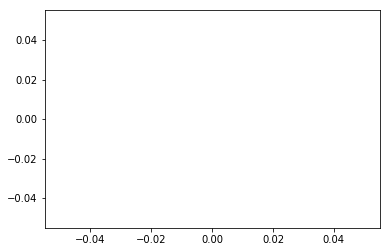

In [8]:
behav_df = pd.read_csv(behav_csv, index_col='subjid', usecols=['subjid', happy_sad_label])
behav_array = behav_df.loc[subj_per_run].values.flatten()
[corr, p_val] = scipy.stats.spearmanr(weight_proj[labels==1],behav_array[labels==1])
plt.plot()
#if corr < 0:
#    svm_proj *= -1
print("Correlation: {}\np-val:{}".format(corr,p_val))

## Plot ranks of behavior vs weight projections

### Make logistic and cognitive ranking

In [9]:
y = 100-scipy.stats.rankdata(behav_array[labels==1])/len(behav_array[labels==1])* 100
x = scipy.stats.rankdata(weight_proj[labels==1])/len(weight_proj[labels==1])* 100

### Make scatter plot
Define color palette:

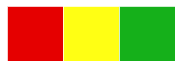

In [10]:
clist = np.array([sns.xkcd_rgb["red"], sns.xkcd_rgb["yellow"], sns.xkcd_rgb["green"]])
#clist = np.array([sns.xkcd_rgb["green"], sns.xkcd_rgb["red"], sns.xkcd_rgb["yellow"]])
pal = sns.color_palette(clist)

sns.set_style("darkgrid")
sns.set_palette(pal)
sns.palplot(sns.color_palette())

Define dataframe for plotting function:

In [11]:
plt_idx = ~np.isnan(happy_sad_labels)
subgroup_names = {-1: 'fast decay', 0:'intermediate', 1: 'stable'}
subgroup = np.array([subgroup_names[k] for k in happy_sad_labels[plt_idx]])
plot_df = pd.DataFrame.from_dict({'weight_rank':x, 'behav_rank':y, 'subgroup': subgroup}) #happy_sad_labels[plt_idx]})#

Make plot and save:

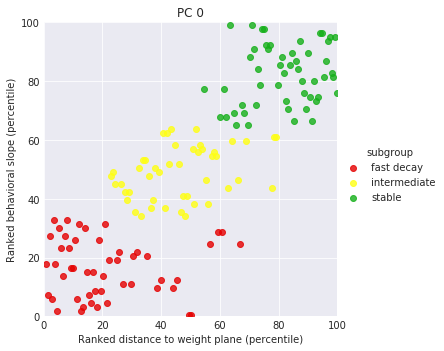

In [12]:
ahs = sns.lmplot('weight_rank', 'behav_rank', plot_df, fit_reg=False, hue='subgroup',
                 hue_order=['fast decay', 'intermediate',  'stable'])
ah = ahs.axes.flatten()[0]
ah.set_xlim([0, 100])
ah.set_ylim([0, 100])
ah.set_xlabel('Ranked distance to weight plane (percentile)')
ah.set_ylabel('Ranked behavioral slope (percentile)')
ah.set_title(happy_sad_label.replace('_', ' '))
ah.set_aspect('equal')
fh = plt.gcf()
if do_save:
    fh.savefig(opj(fig_dir, 'weight_vs_behav_ranks.pdf'))

## To what extent is the observed correlation explained by within-group variance

In [13]:
rank_df = plot_df
n_iter = 10000#00
shuffle=True
replacement=False
subgroup_names = ['intermediate']

chance_corr = TON_tools.provide_subgroup_preserving_ranking_correlation_dist(rank_df, subgroup_names,
                                                                             runs_per_subj,n_iter, shuffle=shuffle,
                                                                             replacement=replacement)
z = scipy.stats.pearsonr(*plot_df.loc[plot_df['subgroup']
                                      == 'intermediate'][['behav_rank','weight_rank']].values.T)[0]
                                                                             
p_val = sum(chance_corr >= z) / n_iter
print(("For the  intermediate subjects not considered in classifier "
      "training the observed correlation is {}, with p-value {}").format(z, p_val))

For the  intermediate subjects not considered in classifier training the observed correlation is 0.355215016955, with p-value 0.0407
